In [10]:
# BLOCK 1: Setup and Configuration

import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Concatenate, Add
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import pandas as pd
from datetime import datetime
from sklearn.metrics import confusion_matrix, classification_report
import gc  # Garbage collector

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Memory optimization settings
IMG_SIZE = (64, 64)  # Downsized from 128x128 to 64x64
BATCH_SIZE = 32
MAX_SAMPLES_PER_CLASS = 2000  # Limit samples per class to reduce memory usage

# Set up GPU memory growth to avoid OOM errors
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

print("Setup complete. Using image size:", IMG_SIZE)
print("Maximum samples per class:", MAX_SAMPLES_PER_CLASS)

Setup complete. Using image size: (64, 64)
Maximum samples per class: 2000


In [11]:
# BLOCK 2: Data Loading with Memory Optimization

def load_and_preprocess_data(base_path="C:\\DEEP LEARNING\\project1_start_code_new", 
                           img_size=IMG_SIZE, max_per_class=MAX_SAMPLES_PER_CLASS):
    """
    Load and preprocess data with memory optimizations
    
    Args:
        base_path: Path to directory containing datasets
        img_size: Image size for resizing (smaller)
        max_per_class: Maximum number of samples per class to use
    
    Returns:
        X_train, X_val, X_test, y_train, y_val, y_test: Split datasets
    """
    print(f"Loading and preprocessing data with reduced image size: {img_size}")
    
    # Dataset paths
    dataset_dirs = ['pariyakorn_chuisakun', 'reubin_george', 'fares_ibrahim']
    
    # Lists to store images and labels
    well_mixed_images = []
    not_mixed_images = []
    well_mixed_count = 0
    not_mixed_count = 0
    
    # Load data from each dataset with limits
    for dataset_dir in dataset_dirs:
        # Well-mixed images (label 1)
        if well_mixed_count < max_per_class:
            well_mixed_path = os.path.join(base_path, dataset_dir, 'well-mixed')
            if os.path.exists(well_mixed_path):
                for img_name in os.listdir(well_mixed_path):
                    if well_mixed_count >= max_per_class:
                        break
                    if img_name.endswith(('.jpg', '.png', '.jpeg')):
                        img_path = os.path.join(well_mixed_path, img_name)
                        try:
                            img = tf.keras.preprocessing.image.load_img(img_path, target_size=img_size)
                            img_array = tf.keras.preprocessing.image.img_to_array(img)
                            img_array = img_array / 255.0  # Normalize to [0,1]
                            well_mixed_images.append(img_array)
                            well_mixed_count += 1
                            if well_mixed_count % 100 == 0:
                                print(f"Loaded {well_mixed_count} well-mixed images")
                        except Exception as e:
                            print(f"Error loading {img_path}: {e}")
        
        # Not-mixed images (label 0)
        if not_mixed_count < max_per_class:
            not_mixed_path = os.path.join(base_path, dataset_dir, 'not-mixed')
            if os.path.exists(not_mixed_path):
                for img_name in os.listdir(not_mixed_path):
                    if not_mixed_count >= max_per_class:
                        break
                    if img_name.endswith(('.jpg', '.png', '.jpeg')):
                        img_path = os.path.join(not_mixed_path, img_name)
                        try:
                            img = tf.keras.preprocessing.image.load_img(img_path, target_size=img_size)
                            img_array = tf.keras.preprocessing.image.img_to_array(img)
                            img_array = img_array / 255.0  # Normalize to [0,1]
                            not_mixed_images.append(img_array)
                            not_mixed_count += 1
                            if not_mixed_count % 100 == 0:
                                print(f"Loaded {not_mixed_count} not-mixed images")
                        except Exception as e:
                            print(f"Error loading {img_path}: {e}")
    
    # Load data from phuong_pham dataset (CSV format)
    phuong_pham_dir = os.path.join(base_path, 'phuong_pham')
    if os.path.exists(phuong_pham_dir):
        print("Loading phuong_pham dataset...")
        csv_path = os.path.join(phuong_pham_dir, 'image_labels.csv')
        
        # If CSV file exists, load it
        if os.path.exists(csv_path):
            try:
                # Read CSV file
                import csv
                with open(csv_path, 'r') as f:
                    csv_reader = csv.reader(f)
                    
                    # Skip header row if it exists
                    try:
                        header = next(csv_reader, None)
                        # Check if header contains non-numeric values in the label column
                        if header and len(header) > 1 and not header[1].isdigit():
                            print(f"Skipping header row: {header}")
                        else:
                            # If header was not a header but data, process it
                            process_csv_row(header, phuong_pham_dir, img_size, 
                                           well_mixed_images, not_mixed_images,
                                           well_mixed_count, not_mixed_count, max_per_class)
                    except (ValueError, IndexError) as e:
                        print(f"Error processing header row: {e}")
                    
                    # Process the rest of the rows
                    for row in csv_reader:
                        try:
                            result = process_csv_row(row, phuong_pham_dir, img_size,
                                                   well_mixed_images, not_mixed_images,
                                                   well_mixed_count, not_mixed_count, max_per_class)
                            # Update counters
                            if result == 1:
                                well_mixed_count += 1
                                if well_mixed_count % 100 == 0:
                                    print(f"Loaded {well_mixed_count} well-mixed images")
                            elif result == 0:
                                not_mixed_count += 1
                                if not_mixed_count % 100 == 0:
                                    print(f"Loaded {not_mixed_count} not-mixed images")
                        except Exception as e:
                            print(f"Error processing row {row}: {e}")
                            
            except Exception as e:
                print(f"Error reading CSV file {csv_path}: {e}")
    
    # Load data from yuhang_wang dataset (images contain class names in filenames)
    yuhang_wang_dir = os.path.join(base_path, 'yuhang_wang')
    if os.path.exists(yuhang_wang_dir):
        print("Loading yuhang_wang dataset...")
        
        # List all image folders (Figs, Figs_port_23006, Figs_port_23010)
        for folder_name in ['Figs', 'Figs_port_23006', 'Figs_port_23010']:
            folder_path = os.path.join(yuhang_wang_dir, folder_name)
            if os.path.exists(folder_path):
                for img_name in os.listdir(folder_path):
                    if img_name.endswith(('.jpg', '.png', '.jpeg')):
                        img_path = os.path.join(folder_path, img_name)
                        try:
                            # Check if filename contains classification
                            is_well_mixed = 'well-mixed' in img_name.lower() or 'well_mixed' in img_name.lower()
                            is_not_mixed = 'not-mixed' in img_name.lower() or 'not_mixed' in img_name.lower()
                            
                            # If not explicitly labeled, skip
                            if not (is_well_mixed or is_not_mixed):
                                # Try to parse from the episode_step naming convention
                                if 'episode' in img_name and 'step' in img_name:
                                    # Check if last part after underscore contains label
                                    parts = img_name.split('_')
                                    if len(parts) >= 3:
                                        last_part = parts[-1].lower()
                                        if 'well-mixed' in last_part or 'well_mixed' in last_part:
                                            is_well_mixed = True
                                        elif 'not-mixed' in last_part or 'not_mixed' in last_part:
                                            is_not_mixed = True
                            
                            # If still not determined, continue to next file
                            if not (is_well_mixed or is_not_mixed):
                                continue
                                
                            # Load and process image
                            img = tf.keras.preprocessing.image.load_img(img_path, target_size=img_size)
                            img_array = tf.keras.preprocessing.image.img_to_array(img)
                            img_array = img_array / 255.0  # Normalize to [0,1]
                            
                            if is_well_mixed and well_mixed_count < max_per_class:
                                well_mixed_images.append(img_array)
                                well_mixed_count += 1
                                if well_mixed_count % 100 == 0:
                                    print(f"Loaded {well_mixed_count} well-mixed images")
                            elif is_not_mixed and not_mixed_count < max_per_class:
                                not_mixed_images.append(img_array)
                                not_mixed_count += 1
                                if not_mixed_count % 100 == 0:
                                    print(f"Loaded {not_mixed_count} not-mixed images")
                        except Exception as e:
                            print(f"Error loading {img_path}: {e}")
    
    print(f"Total images loaded: {well_mixed_count} well-mixed, {not_mixed_count} not-mixed")
    
    # Combining and balancing the dataset
    print("Balancing dataset...")
    min_count = min(len(well_mixed_images), len(not_mixed_images))
    print(f"Balancing to {min_count} images per class")
    well_mixed_images = well_mixed_images[:min_count]
    not_mixed_images = not_mixed_images[:min_count]
    
    # Convert lists to numpy arrays
    print("Converting to numpy arrays...")
    X_well_mixed = np.array(well_mixed_images, dtype=np.float32)
    X_not_mixed = np.array(not_mixed_images, dtype=np.float32)
    
    # Create labels
    y_well_mixed = np.ones(len(X_well_mixed), dtype=np.int8)
    y_not_mixed = np.zeros(len(X_not_mixed), dtype=np.int8)
    
    # Combine data
    X = np.concatenate([X_well_mixed, X_not_mixed], axis=0)
    y = np.concatenate([y_well_mixed, y_not_mixed], axis=0)
    
    # Clear individual arrays to free memory
    X_well_mixed = None
    X_not_mixed = None
    well_mixed_images = None
    not_mixed_images = None
    gc.collect()  # Force garbage collection
    
    # Shuffle the data
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]
    
    # Split data: 70% train, 15% validation, 15% test
    train_size = int(0.7 * len(X))
    val_size = int(0.15 * len(X))
    
    X_train = X[:train_size]
    y_train = y[:train_size]
    
    X_val = X[train_size:train_size+val_size]
    y_val = y[train_size:train_size+val_size]
    
    X_test = X[train_size+val_size:]
    y_test = y[train_size+val_size:]
    
    # Clear combined array to free memory
    X = None
    y = None
    gc.collect()  # Force garbage collection
    
    print(f"Dataset loaded:")
    print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
    print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
    
    # Check class balance
    print(f"Class distribution - Train: {np.bincount(y_train)}")
    print(f"Class distribution - Val: {np.bincount(y_val)}")
    print(f"Class distribution - Test: {np.bincount(y_test)}")
    
    return X_train, X_val, X_test, y_train, y_val, y_test

def process_csv_row(row, base_dir, img_size, well_mixed_images, not_mixed_images, 
                   well_mixed_count, not_mixed_count, max_per_class):
    """Helper function to process a CSV row and load image if possible"""
    if not row or len(row) < 2:
        return -1
    
    try:
        img_name = row[0]
        label = int(row[1])
        
        img_path = os.path.join(base_dir, 'images', img_name)
        if os.path.exists(img_path):
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=img_size)
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            img_array = img_array / 255.0  # Normalize to [0,1]
            
            if label == 1 and well_mixed_count < max_per_class:
                well_mixed_images.append(img_array)
                return 1  # Added to well-mixed
            elif label == 0 and not_mixed_count < max_per_class:
                not_mixed_images.append(img_array)
                return 0  # Added to not-mixed
        return -1  # Not added
    except Exception as e:
        print(f"Error processing row {row}: {e}")
        return -1  # Error case

# Load and preprocess the data
X_train, X_val, X_test, y_train, y_val, y_test = load_and_preprocess_data()

Loading and preprocessing data with reduced image size: (64, 64)
Loaded 100 well-mixed images
Loaded 200 well-mixed images
Loaded 300 well-mixed images
Loaded 400 well-mixed images
Loaded 500 well-mixed images
Loaded 600 well-mixed images
Loaded 700 well-mixed images
Loaded 800 well-mixed images
Loaded 900 well-mixed images
Loaded 1000 well-mixed images
Loaded 1100 well-mixed images
Loaded 1200 well-mixed images
Loaded 1300 well-mixed images
Loaded 1400 well-mixed images
Loaded 1500 well-mixed images
Loaded 1600 well-mixed images
Loaded 1700 well-mixed images
Loaded 1800 well-mixed images
Loaded 1900 well-mixed images
Loaded 2000 well-mixed images
Loaded 100 not-mixed images
Loaded 200 not-mixed images
Loaded 300 not-mixed images
Loaded 400 not-mixed images
Loaded 500 not-mixed images
Loaded 600 not-mixed images
Loaded 700 not-mixed images
Loaded 800 not-mixed images
Loaded 900 not-mixed images
Loaded 1000 not-mixed images
Loaded 1100 not-mixed images
Loaded 1200 not-mixed images
Loade

In [12]:
# BLOCK 3: Save Preprocessed Dataset

# Create a directory to save the preprocessed data
os.makedirs("mixing_dataset_small", exist_ok=True)

# Save the data
print("Saving preprocessed data...")
np.save("mixing_dataset_small/X_train.npy", X_train)
np.save("mixing_dataset_small/y_train.npy", y_train)
np.save("mixing_dataset_small/X_val.npy", X_val)
np.save("mixing_dataset_small/y_val.npy", y_val)
np.save("mixing_dataset_small/X_test.npy", X_test)
np.save("mixing_dataset_small/y_test.npy", y_test)

print("Dataset saved to 'mixing_dataset_small' directory")

# Save dataset info
dataset_info = {
    'img_size': IMG_SIZE,
    'max_samples_per_class': MAX_SAMPLES_PER_CLASS,
    'train_size': len(X_train),
    'val_size': len(X_val),
    'test_size': len(X_test),
    'train_class_distribution': np.bincount(y_train).tolist(),
    'val_class_distribution': np.bincount(y_val).tolist(),
    'test_class_distribution': np.bincount(y_test).tolist()
}

# Save as CSV for easy viewing
pd.DataFrame([dataset_info]).to_csv("mixing_dataset_small/dataset_info.csv", index=False)
print("Dataset info saved to 'mixing_dataset_small/dataset_info.csv'")

Saving preprocessed data...
Dataset saved to 'mixing_dataset_small' directory
Dataset info saved to 'mixing_dataset_small/dataset_info.csv'


In [13]:
# BLOCK 4: Model Architecture Functions

def inception_module(x, filters_1x1, filters_3x3_reduce, filters_3x3, filters_5x5_reduce, filters_5x5, filters_pool_proj):
    """
    Implementation of an Inception module (simplified for memory efficiency)
    """
    # 1x1 convolution path
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')(x)
    
    # 3x3 convolution path
    conv_3x3_reduce = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu')(conv_3x3_reduce)
    
    # 5x5 convolution path
    conv_5x5_reduce = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(x)
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu')(conv_5x5_reduce)
    
    # Pool projection path
    pool_proj = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu')(pool_proj)
    
    # Concatenate all paths
    output = Concatenate(axis=-1)([conv_1x1, conv_3x3, conv_5x5, pool_proj])
    
    return output

def residual_block(x, filters, kernel_size=3, use_batchnorm=True, dropout_rate=0):
    """
    Implementation of a residual block (simplified for memory efficiency)
    """
    # Store input
    shortcut = x
    
    # First convolution
    x = Conv2D(filters, kernel_size, padding='same')(x)
    if use_batchnorm:
        x = BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    # Second convolution
    x = Conv2D(filters, kernel_size, padding='same')(x)
    if use_batchnorm:
        x = BatchNormalization()(x)
    
    # Handle shortcut dimension mismatch
    if shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, (1, 1), padding='same')(shortcut)
        if use_batchnorm:
            shortcut = BatchNormalization()(shortcut)
    
    # Add shortcut to output
    x = Add()([x, shortcut])
    x = tf.keras.layers.Activation('relu')(x)
    
    # Apply dropout if specified
    if dropout_rate > 0:
        x = Dropout(dropout_rate)(x)
    
    return x

def create_model(input_shape=IMG_SIZE + (3,), use_batchnorm=True, dropout_rate=0.3,
                use_inception=True, use_residual=True):
    """
    Create a simplified CNN model with various techniques
    """
    inputs = Input(shape=input_shape)
    
    # Initial convolution
    x = Conv2D(16, (3, 3), padding='same', activation='relu')(inputs)  # Reduced from 32 filters
    if use_batchnorm:
        x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    
    # First block
    if use_residual:
        x = residual_block(x, 32, use_batchnorm=use_batchnorm, dropout_rate=dropout_rate)  # Reduced from 64 filters
    else:
        x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)  # Reduced from 64 filters
        if use_batchnorm:
            x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    
    # Second block (with inception module if enabled)
    if use_inception:
        x = inception_module(x, 32, 48, 64, 8, 16, 16)  # Reduced filter counts by 50%
    else:
        x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)  # Reduced from 128 filters
        if use_batchnorm:
            x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    
    # Final layers
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)  # Reduced from 512 units
    if use_batchnorm:
        x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 
                 tf.keras.metrics.AUC()]
    )
    
    return model

def train_model(X_train, y_train, X_val, y_val, config, output_dir="model_results"):
    """
    Train a CNN model with the specified configuration
    """
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Generate a unique model name based on config
    model_name = f"mixing_cnn_bn{int(config['use_batchnorm'])}_do{config['dropout_rate']}_" \
                 f"inception{int(config['use_inception'])}_residual{int(config['use_residual'])}"
    
    # Create model
    model = create_model(
        input_shape=X_train.shape[1:],
        use_batchnorm=config['use_batchnorm'],
        dropout_rate=config['dropout_rate'],
        use_inception=config['use_inception'],
        use_residual=config['use_residual']
    )
    
    # Print model summary
    model.summary()
    
    # Data augmentation
    if config['use_augmentation']:
        datagen = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.1,
            zoom_range=0.1,
            horizontal_flip=True,
            vertical_flip=True,
            fill_mode='nearest'
        )
        datagen.fit(X_train)
    
    # Callbacks
    checkpoint = ModelCheckpoint(
        os.path.join(output_dir, f"{model_name}.h5"),
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        mode='max'
    )
    
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,  # Reduced from 10
        verbose=1,
        restore_best_weights=True
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,  # Reduced from 5
        verbose=1,
        min_lr=1e-6
    )
    
    callbacks = [checkpoint, early_stopping, reduce_lr]
    
    # Train model
    if config['use_augmentation']:
        history = model.fit(
            datagen.flow(X_train, y_train, batch_size=config['batch_size']),
            steps_per_epoch=len(X_train) // config['batch_size'],
            epochs=config['epochs'],
            validation_data=(X_val, y_val),
            callbacks=callbacks,
            verbose=1
        )
    else:
        history = model.fit(
            X_train, y_train,
            batch_size=config['batch_size'],
            epochs=config['epochs'],
            validation_data=(X_val, y_val),
            callbacks=callbacks,
            verbose=1
        )
    
    # Save training history
    pd.DataFrame(history.history).to_csv(os.path.join(output_dir, f"{model_name}_history.csv"))
    
    # Plot training & validation loss and accuracy
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"{model_name}_training_curves.png"))
    
    return model, history

def evaluate_model(model, X_test, y_test, config, output_dir="model_results"):
    """
    Evaluate a model on test data
    """
    # Generate a unique model name based on config
    model_name = f"mixing_cnn_bn{int(config['use_batchnorm'])}_do{config['dropout_rate']}_" \
                 f"inception{int(config['use_inception'])}_residual{int(config['use_residual'])}"
    
    # Evaluate model
    results = model.evaluate(X_test, y_test, verbose=1)
    
    # Get model predictions
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()
    
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    
    # Save results
    eval_results = {
        'test_loss': results[0],
        'test_accuracy': results[1],
        'test_precision': results[2],
        'test_recall': results[3],
        'test_auc': results[4],
        'confusion_matrix': cm,
        'classification_report': report
    }
    
    # Print results
    print(f"Test Loss: {results[0]:.4f}")
    print(f"Test Accuracy: {results[1]:.4f}")
    print(f"Test Precision: {results[2]:.4f}")
    print(f"Test Recall: {results[3]:.4f}")
    print(f"Test AUC: {results[4]:.4f}")
    print("\nConfusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    classes = ['Not-Mixed', 'Well-Mixed']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    # Add text annotations
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(os.path.join(output_dir, f"{model_name}_confusion_matrix.png"))
    
    # Save results as CSV
    results_df = pd.DataFrame({
        'Metric': ['Loss', 'Accuracy', 'Precision', 'Recall', 'AUC'],
        'Value': [results[0], results[1], results[2], results[3], results[4]]
    })
    results_df.to_csv(os.path.join(output_dir, f"{model_name}_test_results.csv"), index=False)
    
    return eval_results

Training baseline model...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 548,129 (2.09 MB)

 Trainable params: 548,129 (2.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
86/88 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9073 - auc: 0.9570 - loss: 0.2211 - precision: 0.8906 - recall: 0.9193
Epoch 1: val_accuracy improved from -inf to 0.99833, saving model to model_results_20250316_005602\mixing_cnn_bn0_do0.0_inception0_residual0.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.9096 - auc: 0.9584 - loss: 0.2160 - precision: 0.8934 - recall: 0.9214 - val_accuracy: 0.9983 - val_auc: 1.0000 - val_loss: 0.0051 - val_precision: 1.0000 - val_recall: 0.9966 - learning_rate: 0.0010
Epoch 2/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9996 - auc: 1.0000 - loss: 0.0020 - precision: 1.0000 - recall: 0.9992
Epoch 2: val_accuracy improved from 0.99833 to 1.00000, saving model to model_results_20250316_005602\mixing_cnn_bn0_do0.0_inception0_residual0.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9996 - auc: 1.0000 - loss: 0.0020 - precision: 1.0000 - recall: 0.9992 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 3.0359e-04 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/15
85/88 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 2.6162e-05 - precision: 1.0000 - recall: 1.0000
Epoch 3: val_accuracy did not improve from 1.00000
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 2.6998e-05 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.0016 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 4/15
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 2.6312e-05 - precision: 1.0000 - recall: 1.0000
Epoch 4: val_accuracy did not improve from 1.00000
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 2.6272e-05 - precisio

0

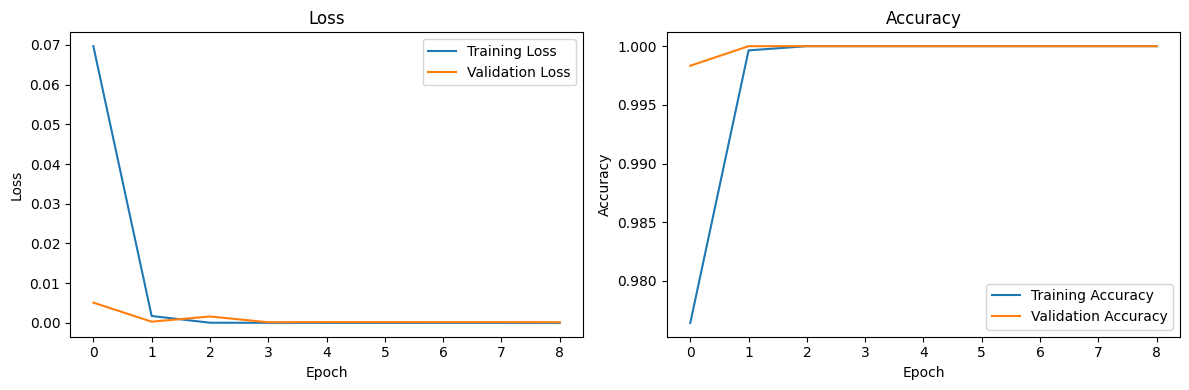

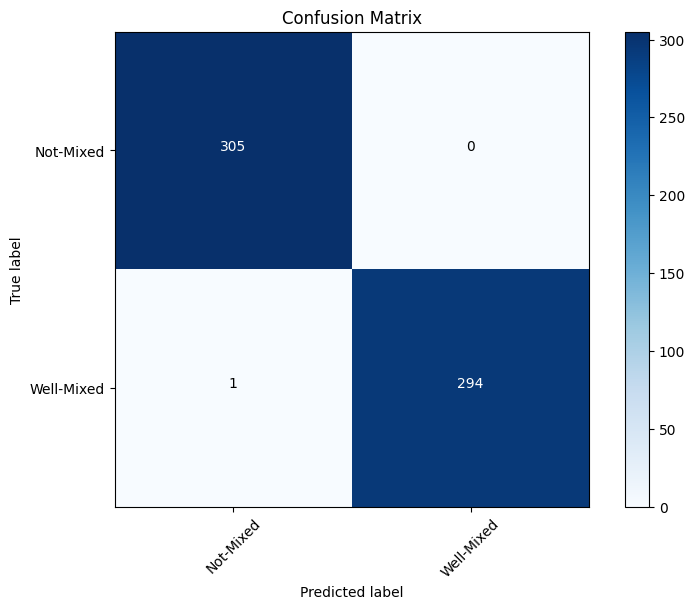

In [14]:
# BLOCK 5: Train Baseline Model

# Create output directory
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_dir = f"model_results_{timestamp}"
os.makedirs(output_dir, exist_ok=True)

# Define baseline configuration
baseline_config = {
    'name': 'Baseline',
    'use_batchnorm': False,
    'dropout_rate': 0.0,
    'use_inception': False,
    'use_residual': False,
    'use_augmentation': False,
    'batch_size': 32,
    'epochs': 15  # Reduced epochs
}

print(f"Training baseline model...")
baseline_model, baseline_history = train_model(
    X_train, y_train, X_val, y_val, baseline_config, output_dir
)

# Evaluate baseline model
print(f"Evaluating baseline model...")
baseline_results = evaluate_model(
    baseline_model, X_test, y_test, baseline_config, output_dir
)

# Save model parameters and performance
baseline_summary = {
    'model': 'Baseline',
    'parameters': baseline_config,
    'test_accuracy': baseline_results['test_accuracy'],
    'test_precision': baseline_results['test_precision'],
    'test_recall': baseline_results['test_recall'],
    'test_auc': baseline_results['test_auc']
}

# Save as CSV
pd.DataFrame([baseline_summary]).to_csv(os.path.join(output_dir, "baseline_summary.csv"), index=False)

# Clear memory
tf.keras.backend.clear_session()
gc.collect()

Training model with batch normalization...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 549,089 (2.09 MB)

 Trainable params: 548,609 (2.09 MB)

 Non-trainable params: 480 (1.88 KB)

Epoch 1/15
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9676 - auc: 0.9908 - loss: 0.0541 - precision: 0.9733 - recall: 0.9609
Epoch 1: val_accuracy improved from -inf to 0.64000, saving model to model_results_20250316_005602\mixing_cnn_bn1_do0.0_inception0_residual0.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.9682 - auc: 0.9910 - loss: 0.0532 - precision: 0.9737 - recall: 0.9615 - val_accuracy: 0.6400 - val_auc: 1.0000 - val_loss: 0.4409 - val_precision: 1.0000 - val_recall: 0.2752 - learning_rate: 0.0010
Epoch 2/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 6.5527e-04 - precision: 1.0000 - recall: 1.0000
Epoch 2: val_accuracy improved from 0.64000 to 0.91333, saving model to model_results_20250316_005602\mixing_cnn_bn1_do0.0_inception0_residual0.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 6.5379e-04 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.9133 - val_auc: 1.0000 - val_loss: 0.2485 - val_precision: 1.0000 - val_recall: 0.8255 - learning_rate: 0.0010
Epoch 3/15
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 4.4763e-04 - precision: 1.0000 - recall: 1.0000
Epoch 3: val_accuracy improved from 0.91333 to 0.97667, saving model to model_results_20250316_005602\mixing_cnn_bn1_do0.0_inception0_residual0.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 4.4485e-04 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.9767 - val_auc: 1.0000 - val_loss: 0.1468 - val_precision: 1.0000 - val_recall: 0.9530 - learning_rate: 0.0010
Epoch 4/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 2.7232e-04 - precision: 1.0000 - recall: 1.0000
Epoch 4: val_accuracy improved from 0.97667 to 0.99833, saving model to model_results_20250316_005602\mixing_cnn_bn1_do0.0_inception0_residual0.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 2.7169e-04 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.9983 - val_auc: 1.0000 - val_loss: 0.0281 - val_precision: 1.0000 - val_recall: 0.9966 - learning_rate: 0.0010
Epoch 5/15
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 2.0736e-04 - precision: 1.0000 - recall: 1.0000
Epoch 5: val_accuracy improved from 0.99833 to 1.00000, saving model to model_results_20250316_005602\mixing_cnn_bn1_do0.0_inception0_residual0.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 2.0641e-04 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.0043 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 6/15
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 1.6303e-04 - precision: 1.0000 - recall: 1.0000
Epoch 6: val_accuracy did not improve from 1.00000
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 1.6228e-04 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 8.5175e-04 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 7/15
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 1.3220e-04 - precision: 1.0000 - recall: 1.0000
Epoch 7: val_accuracy did not improve from 1.00000
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 1.3160e-04 - prec

0

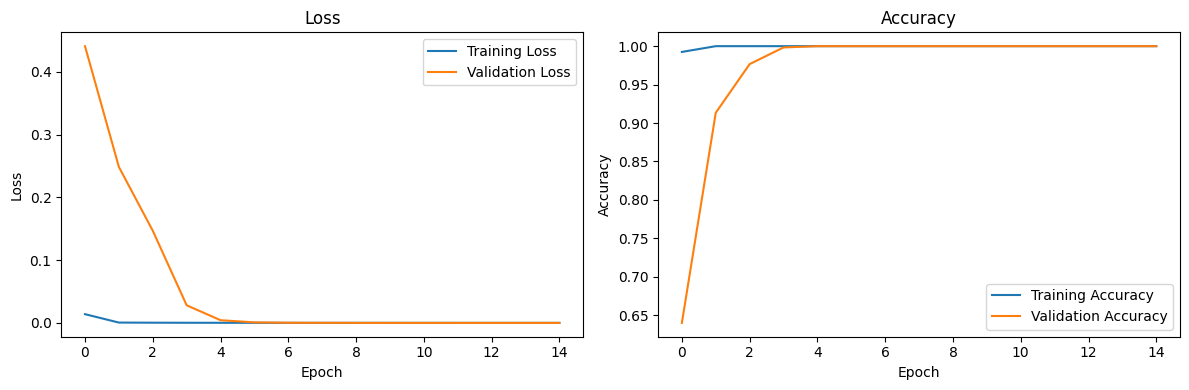

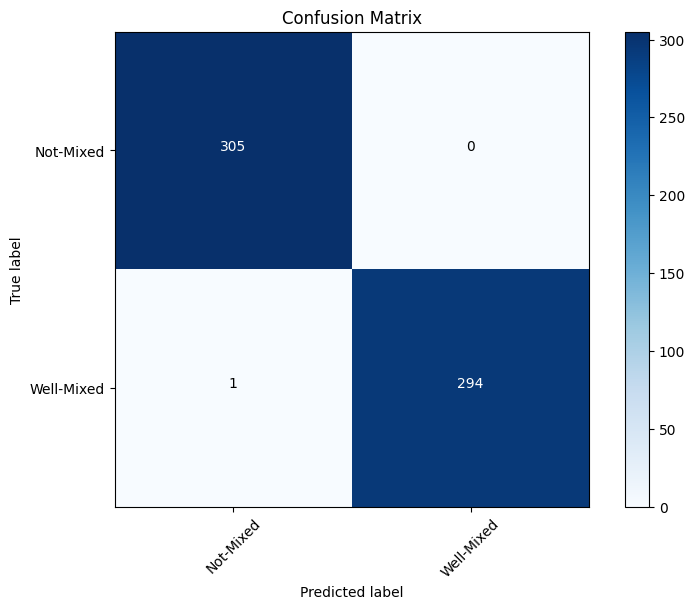

In [15]:
# BLOCK 6: Train Model with Batch Normalization

# Define batch normalization configuration
batchnorm_config = {
    'name': 'With BatchNorm',
    'use_batchnorm': True,
    'dropout_rate': 0.0,
    'use_inception': False,
    'use_residual': False,
    'use_augmentation': False,
    'batch_size': 32,
    'epochs': 15  # Reduced epochs
}

print(f"Training model with batch normalization...")
batchnorm_model, batchnorm_history = train_model(
    X_train, y_train, X_val, y_val, batchnorm_config, output_dir
)

# Evaluate model with batch normalization
print(f"Evaluating model with batch normalization...")
batchnorm_results = evaluate_model(
    batchnorm_model, X_test, y_test, batchnorm_config, output_dir
)

# Save model parameters and performance
batchnorm_summary = {
    'model': 'With BatchNorm',
    'parameters': batchnorm_config,
    'test_accuracy': batchnorm_results['test_accuracy'],
    'test_precision': batchnorm_results['test_precision'],
    'test_recall': batchnorm_results['test_recall'],
    'test_auc': batchnorm_results['test_auc']
}

# Save as CSV
pd.DataFrame([batchnorm_summary]).to_csv(os.path.join(output_dir, "batchnorm_summary.csv"), index=False)

# Clear memory
tf.keras.backend.clear_session()
gc.collect()

Training model with dropout...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 548,129 (2.09 MB)

 Trainable params: 548,129 (2.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15


85/88 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8744 - auc: 0.9252 - loss: 0.2765 - precision: 0.8716 - recall: 0.8647
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to model_results_20250316_005602\mixing_cnn_bn0_do0.3_inception0_residual0.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.8785 - auc: 0.9284 - loss: 0.2683 - precision: 0.8759 - recall: 0.8692 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 4.6863e-05 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/15
85/88 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9991 - auc: 1.0000 - loss: 0.0024 - precision: 0.9990 - recall: 0.9992
Epoch 2: val_accuracy did not improve from 1.00000
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9991 - auc: 1.0000 - loss: 0.0024 - precision: 0.9989 - recall: 0.9992 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 2.6776e-04 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/15
85/88 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9996 - auc: 1.0000 - loss: 4.4166e-04 - precision: 1.0000 - recall: 0.9992
Epoch 3: val_accuracy did not improve from 1.00000
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9996 - auc: 1.0000 - loss: 4.4194e-04 - precision: 1

0

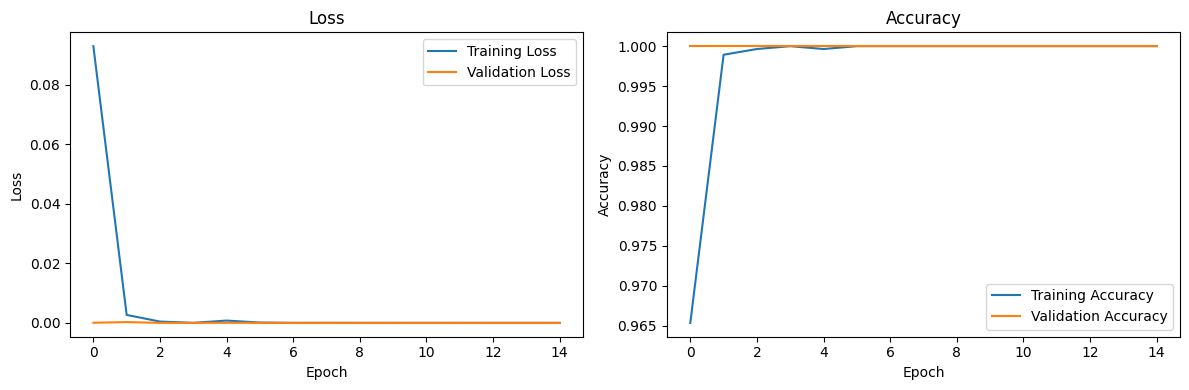

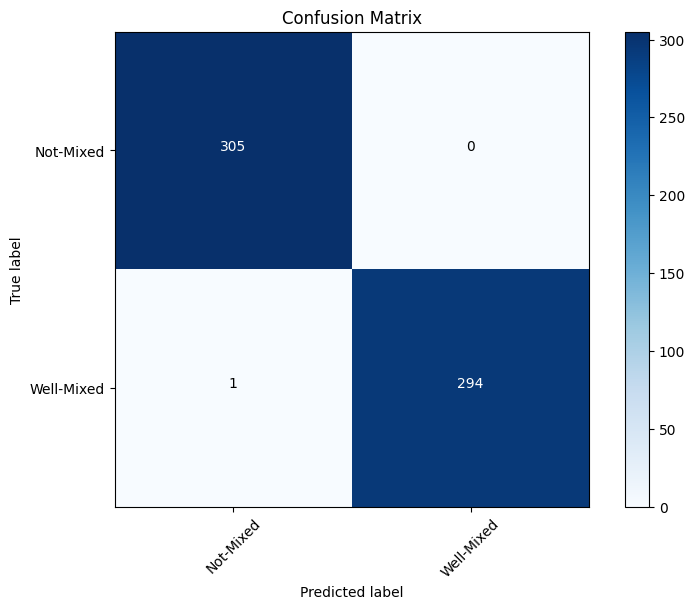

In [16]:
# BLOCK 7: Train Model with Dropout

# Define dropout configuration
dropout_config = {
    'name': 'With Dropout',
    'use_batchnorm': False,
    'dropout_rate': 0.3,
    'use_inception': False,
    'use_residual': False,
    'use_augmentation': False,
    'batch_size': 32,
    'epochs': 15  # Reduced epochs
}

print(f"Training model with dropout...")
dropout_model, dropout_history = train_model(
    X_train, y_train, X_val, y_val, dropout_config, output_dir
)

# Evaluate model with dropout
print(f"Evaluating model with dropout...")
dropout_results = evaluate_model(
    dropout_model, X_test, y_test, dropout_config, output_dir
)

# Save model parameters and performance
dropout_summary = {
    'model': 'With Dropout',
    'parameters': dropout_config,
    'test_accuracy': dropout_results['test_accuracy'],
    'test_precision': dropout_results['test_precision'],
    'test_recall': dropout_results['test_recall'],
    'test_auc': dropout_results['test_auc']
}

# Save as CSV
pd.DataFrame([dropout_summary]).to_csv(os.path.join(output_dir, "dropout_summary.csv"), index=False)

# Clear memory
tf.keras.backend.clear_session()
gc.collect()

Training model with data augmentation...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 548,129 (2.09 MB)

 Trainable params: 548,129 (2.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15


C:\Users\pariy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5284 - auc: 0.5314 - loss: 0.7167 - precision: 0.5068 - recall: 0.6137
Epoch 1: val_accuracy improved from -inf to 0.65167, saving model to model_results_20250316_005602\mixing_cnn_bn0_do0.0_inception0_residual0.h5


87/87 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.5286 - auc: 0.5318 - loss: 0.7164 - precision: 0.5072 - recall: 0.6128 - val_accuracy: 0.6517 - val_auc: 0.7403 - val_loss: 0.6290 - val_precision: 0.6213 - val_recall: 0.7651 - learning_rate: 0.0010
Epoch 2/15
 1/87 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6562 - auc: 0.7937 - loss: 0.6445 - precision: 0.5652 - recall: 0.9286

C:\Users\pariy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy improved from 0.65167 to 0.69500, saving model to model_results_20250316_005602\mixing_cnn_bn0_do0.0_inception0_residual0.h5


87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6562 - auc: 0.7937 - loss: 0.6445 - precision: 0.5652 - recall: 0.9286 - val_accuracy: 0.6950 - val_auc: 0.7566 - val_loss: 0.6172 - val_precision: 0.7751 - val_recall: 0.5436 - learning_rate: 0.0010
Epoch 3/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6876 - auc: 0.7442 - loss: 0.5988 - precision: 0.7064 - recall: 0.6841
Epoch 3: val_accuracy improved from 0.69500 to 0.77833, saving model to model_results_20250316_005602\mixing_cnn_bn0_do0.0_inception0_residual0.h5


87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.6877 - auc: 0.7445 - loss: 0.5985 - precision: 0.7064 - recall: 0.6843 - val_accuracy: 0.7783 - val_auc: 0.8741 - val_loss: 0.4623 - val_precision: 0.7538 - val_recall: 0.8221 - learning_rate: 0.0010
Epoch 4/15
 1/87 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.6875 - auc: 0.7734 - loss: 0.5516 - precision: 0.6500 - recall: 0.8125
Epoch 4: val_accuracy improved from 0.77833 to 0.81500, saving model to model_results_20250316_005602\mixing_cnn_bn0_do0.0_inception0_residual0.h5


87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6875 - auc: 0.7734 - loss: 0.5516 - precision: 0.6500 - recall: 0.8125 - val_accuracy: 0.8150 - val_auc: 0.9119 - val_loss: 0.4170 - val_precision: 0.7987 - val_recall: 0.8389 - learning_rate: 0.0010
Epoch 5/15
86/87 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7692 - auc: 0.8624 - loss: 0.4632 - precision: 0.7698 - recall: 0.7709
Epoch 5: val_accuracy improved from 0.81500 to 0.89167, saving model to model_results_20250316_005602\mixing_cnn_bn0_do0.0_inception0_residual0.h5


87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.7696 - auc: 0.8627 - loss: 0.4628 - precision: 0.7701 - recall: 0.7714 - val_accuracy: 0.8917 - val_auc: 0.9617 - val_loss: 0.2705 - val_precision: 0.9117 - val_recall: 0.8658 - learning_rate: 0.0010
Epoch 6/15
 1/87 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.7812 - auc: 0.9008 - loss: 0.4129 - precision: 0.7692 - recall: 0.7143
Epoch 6: val_accuracy did not improve from 0.89167
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7812 - auc: 0.9008 - loss: 0.4129 - precision: 0.7692 - recall: 0.7143 - val_accuracy: 0.8800 - val_auc: 0.9538 - val_loss: 0.2998 - val_precision: 0.9248 - val_recall: 0.8255 - learning_rate: 0.0010
Epoch 7/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8225 - auc: 0.9030 - loss: 0.3939 - precision: 0.8309 - recall: 0.8076
Epoch 7: val_accuracy improved from 0.89167 to 0.95500, saving model to model_results_20250316_005602\mixing_cnn_bn0_do0.0_inception0_residual0.h5


87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.8225 - auc: 0.9031 - loss: 0.3937 - precision: 0.8308 - recall: 0.8078 - val_accuracy: 0.9550 - val_auc: 0.9965 - val_loss: 0.1367 - val_precision: 0.9963 - val_recall: 0.9128 - learning_rate: 0.0010
Epoch 8/15
 1/87 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6875 - auc: 0.8203 - loss: 0.5062 - precision: 0.7500 - recall: 0.5625
Epoch 8: val_accuracy improved from 0.95500 to 0.96333, saving model to model_results_20250316_005602\mixing_cnn_bn0_do0.0_inception0_residual0.h5


87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6875 - auc: 0.8203 - loss: 0.5062 - precision: 0.7500 - recall: 0.5625 - val_accuracy: 0.9633 - val_auc: 0.9974 - val_loss: 0.1242 - val_precision: 0.9964 - val_recall: 0.9295 - learning_rate: 0.0010
Epoch 9/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8281 - auc: 0.9142 - loss: 0.3708 - precision: 0.8387 - recall: 0.8242
Epoch 9: val_accuracy did not improve from 0.96333
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.8282 - auc: 0.9143 - loss: 0.3707 - precision: 0.8386 - recall: 0.8244 - val_accuracy: 0.9267 - val_auc: 0.9813 - val_loss: 0.1918 - val_precision: 0.9320 - val_recall: 0.9195 - learning_rate: 0.0010
Epoch 10/15
 1/87 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7500 - auc: 0.8075 - loss: 0.6331 - precision: 0.8125 - recall: 0.7222
Epoch 10: val_accuracy did not improve from 0.96333
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7500 - auc: 0.8075 - loss: 0.6331 - precision: 0.8125 - recall: 

0

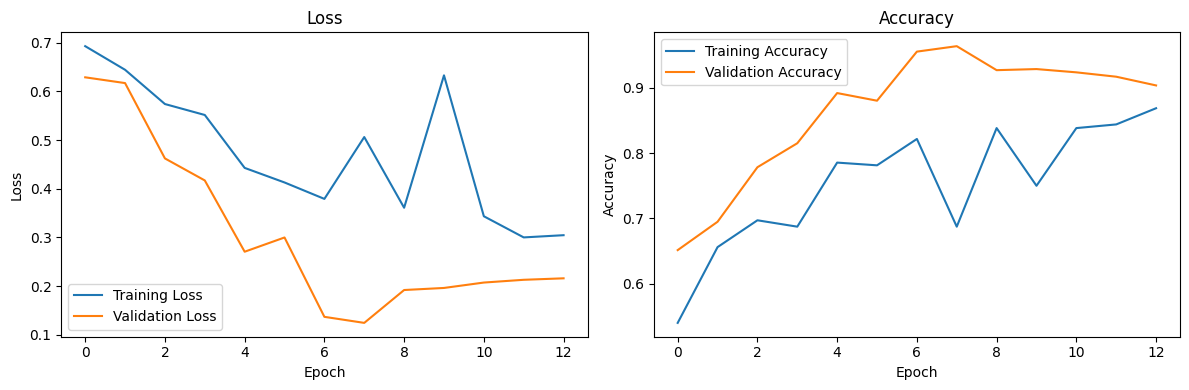

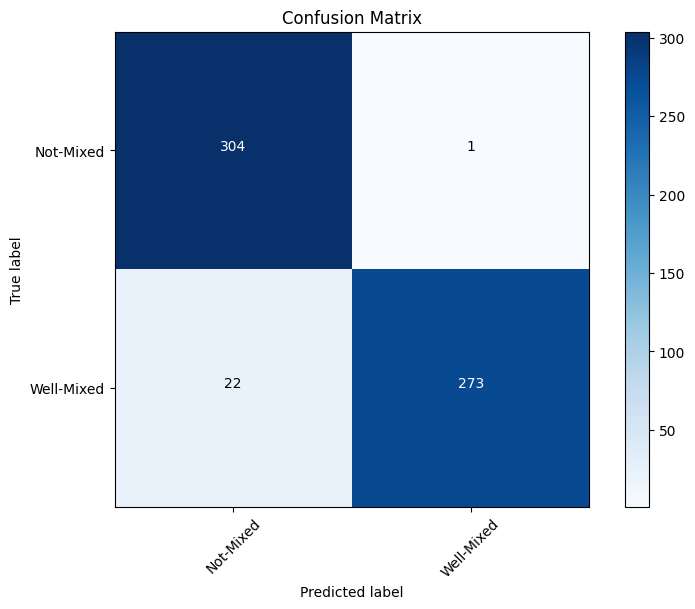

In [17]:
# BLOCK 8: Train Model with Data Augmentation

# Define data augmentation configuration
augmentation_config = {
    'name': 'With Data Augmentation',
    'use_batchnorm': False,
    'dropout_rate': 0.0,
    'use_inception': False,
    'use_residual': False,
    'use_augmentation': True,
    'batch_size': 32,
    'epochs': 15  # Reduced epochs
}

print(f"Training model with data augmentation...")
augmentation_model, augmentation_history = train_model(
    X_train, y_train, X_val, y_val, augmentation_config, output_dir
)

# Evaluate model with data augmentation
print(f"Evaluating model with data augmentation...")
augmentation_results = evaluate_model(
    augmentation_model, X_test, y_test, augmentation_config, output_dir
)

# Save model parameters and performance
augmentation_summary = {
    'model': 'With Data Augmentation',
    'parameters': augmentation_config,
    'test_accuracy': augmentation_results['test_accuracy'],
    'test_precision': augmentation_results['test_precision'],
    'test_recall': augmentation_results['test_recall'],
    'test_auc': augmentation_results['test_auc']
}

# Save as CSV
pd.DataFrame([augmentation_summary]).to_csv(os.path.join(output_dir, "augmentation_summary.csv"), index=False)

# Clear memory
tf.keras.backend.clear_session()
gc.collect()

Training model with inception modules...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 32,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 16, 16,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │      1,584 │ max_pooling2d_1[… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 16, 16, 8) │        264 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ max_pooling2d_1[… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 16,    │      1,056 │ max_pooling2d_1[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 16, 16,    │     27,712 │ conv2d_3[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │      3,216 │ conv2d_5[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │        528 │ max_pooling2d_2[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16, 16,    │          0 │ conv2d_2[0][0],   │
│ (Concatenate)       │ 128)              │            │ conv2d_4[0][0],   │
│                     │                   │            │ conv2d_6[0][0],   │
│                     │                   │            │ conv2d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 128) │          0 │ concatenate[0][0] │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 8192)      │          0 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │  1,048,704 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,088,281 (4.15 MB)

 Trainable params: 1,088,281 (4.15 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
86/88 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8277 - auc: 0.8993 - loss: 0.3315 - precision: 0.8469 - recall: 0.7720
Epoch 1: val_accuracy improved from -inf to 0.99833, saving model to model_results_20250316_005602\mixing_cnn_bn0_do0.0_inception1_residual0.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.8317 - auc: 0.9024 - loss: 0.3244 - precision: 0.8508 - recall: 0.7773 - val_accuracy: 0.9983 - val_auc: 1.0000 - val_loss: 0.0020 - val_precision: 1.0000 - val_recall: 0.9966 - learning_rate: 0.0010
Epoch 2/15
86/88 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9996 - auc: 1.0000 - loss: 0.0011 - precision: 1.0000 - recall: 0.9992
Epoch 2: val_accuracy improved from 0.99833 to 1.00000, saving model to model_results_20250316_005602\mixing_cnn_bn0_do0.0_inception1_residual0.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9996 - auc: 1.0000 - loss: 0.0012 - precision: 1.0000 - recall: 0.9992 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 9.2464e-07 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/15
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 5.5910e-05 - precision: 1.0000 - recall: 1.0000
Epoch 3: val_accuracy did not improve from 1.00000
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 5.6095e-05 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 1.0378e-04 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 4/15
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 1.7863e-05 - precision: 1.0000 - recall: 1.0000
Epoch 4: val_accuracy did not improve from 1.00000
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 1.7756e-05 - prec

0

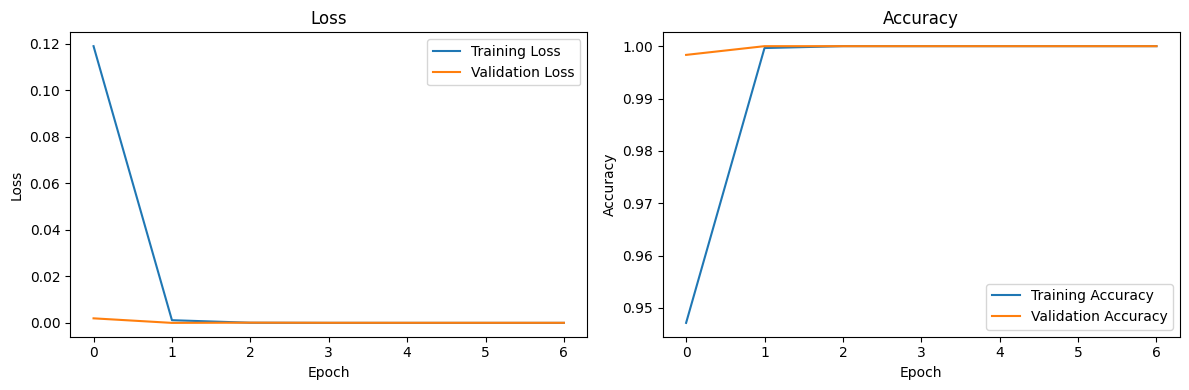

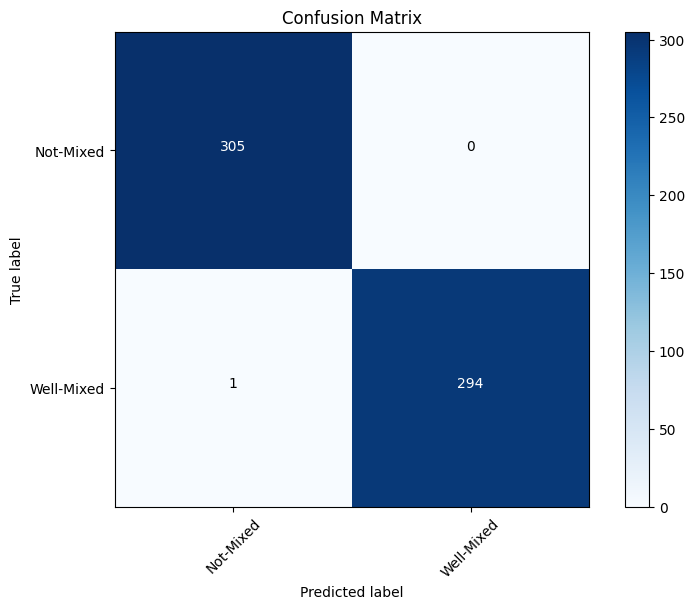

In [18]:
# BLOCK 9: Train Model with Inception Modules

# Define inception module configuration
inception_config = {
    'name': 'With Inception',
    'use_batchnorm': False,
    'dropout_rate': 0.0,
    'use_inception': True,
    'use_residual': False,
    'use_augmentation': False,
    'batch_size': 32,
    'epochs': 15  # Reduced epochs
}

print(f"Training model with inception modules...")
inception_model, inception_history = train_model(
    X_train, y_train, X_val, y_val, inception_config, output_dir
)

# Evaluate model with inception modules
print(f"Evaluating model with inception modules...")
inception_results = evaluate_model(
    inception_model, X_test, y_test, inception_config, output_dir
)

# Save model parameters and performance
inception_summary = {
    'model': 'With Inception',
    'parameters': inception_config,
    'test_accuracy': inception_results['test_accuracy'],
    'test_precision': inception_results['test_precision'],
    'test_recall': inception_results['test_recall'],
    'test_auc': inception_results['test_auc']
}

# Save as CSV
pd.DataFrame([inception_summary]).to_csv(os.path.join(output_dir, "inception_summary.csv"), index=False)

# Clear memory
tf.keras.backend.clear_session()
gc.collect()

Training model with residual connections...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 32,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 32, 32,    │          0 │ conv2d_1[0][0]    │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │      9,248 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │        544 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 32,    │          0 │ conv2d_2[0][0],   │
│                     │ 32)               │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 32, 32,    │          0 │ add[0][0]         │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 16, 16,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 16, 16,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 8, 8, 64)  │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 4096)      │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    524,416 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │        129 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 557,921 (2.13 MB)

 Trainable params: 557,921 (2.13 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8929 - auc: 0.9397 - loss: 0.2513 - precision: 0.9010 - recall: 0.8922
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to model_results_20250316_005602\mixing_cnn_bn0_do0.0_inception0_residual1.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.8937 - auc: 0.9404 - loss: 0.2494 - precision: 0.9018 - recall: 0.8930 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 8.5661e-04 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9996 - auc: 1.0000 - loss: 8.3699e-04 - precision: 1.0000 - recall: 0.9992
Epoch 2: val_accuracy did not improve from 1.00000
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9996 - auc: 1.0000 - loss: 8.3709e-04 - precision: 1.0000 - recall: 0.9992 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 1.9454e-05 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/15
86/88 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 3.7742e-05 - precision: 1.0000 - recall: 1.0000
Epoch 3: val_accuracy did not improve from 1.00000
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 3.7954e-05 - prec

0

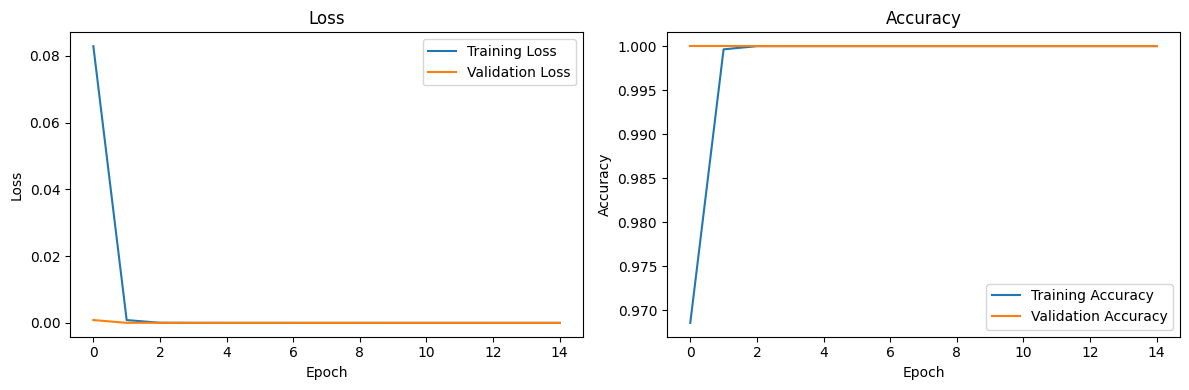

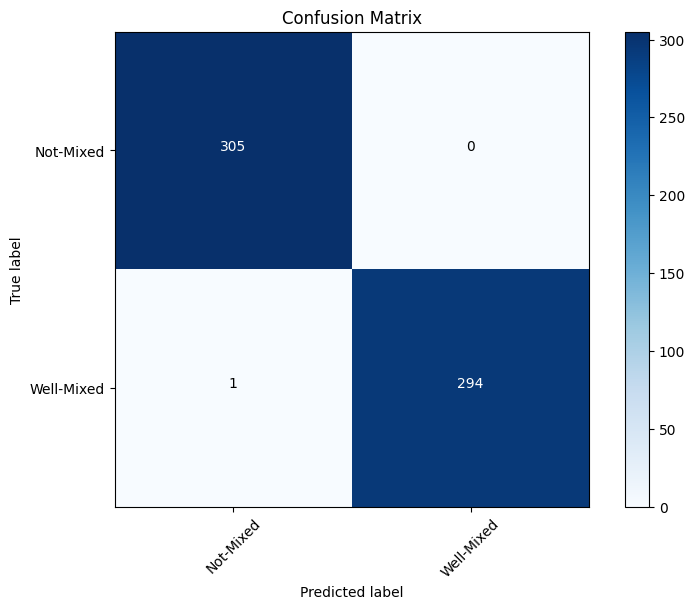

In [19]:
# BLOCK 10: Train Model with Residual Connections

# Define residual connections configuration
residual_config = {
    'name': 'With Residual',
    'use_batchnorm': False,
    'dropout_rate': 0.0,
    'use_inception': False,
    'use_residual': True,
    'use_augmentation': False,
    'batch_size': 32,
    'epochs': 15  # Reduced epochs
}

print(f"Training model with residual connections...")
residual_model, residual_history = train_model(
    X_train, y_train, X_val, y_val, residual_config, output_dir
)

# Evaluate model with residual connections
print(f"Evaluating model with residual connections...")
residual_results = evaluate_model(
    residual_model, X_test, y_test, residual_config, output_dir
)

# Save model parameters and performance
residual_summary = {
    'model': 'With Residual',
    'parameters': residual_config,
    'test_accuracy': residual_results['test_accuracy'],
    'test_precision': residual_results['test_precision'],
    'test_recall': residual_results['test_recall'],
    'test_auc': residual_results['test_auc']
}

# Save as CSV
pd.DataFrame([residual_summary]).to_csv(os.path.join(output_dir, "residual_summary.csv"), index=False)

# Clear memory
tf.keras.backend.clear_session()
gc.collect()


Comparison of Techniques:
                     name  test_accuracy  test_precision  test_recall  \
0                Baseline       0.998333         1.00000     0.996610   
1          With BatchNorm       0.998333         1.00000     0.996610   
2            With Dropout       0.998333         1.00000     0.996610   
3  With Data Augmentation       0.961667         0.99635     0.925424   
4          With Inception       0.998333         1.00000     0.996610   
5           With Residual       0.998333         1.00000     0.996610   

   test_auc  
0  0.998305  
1  0.998305  
2  0.998305  
3  0.998722  
4  0.998305  
5  0.998305  


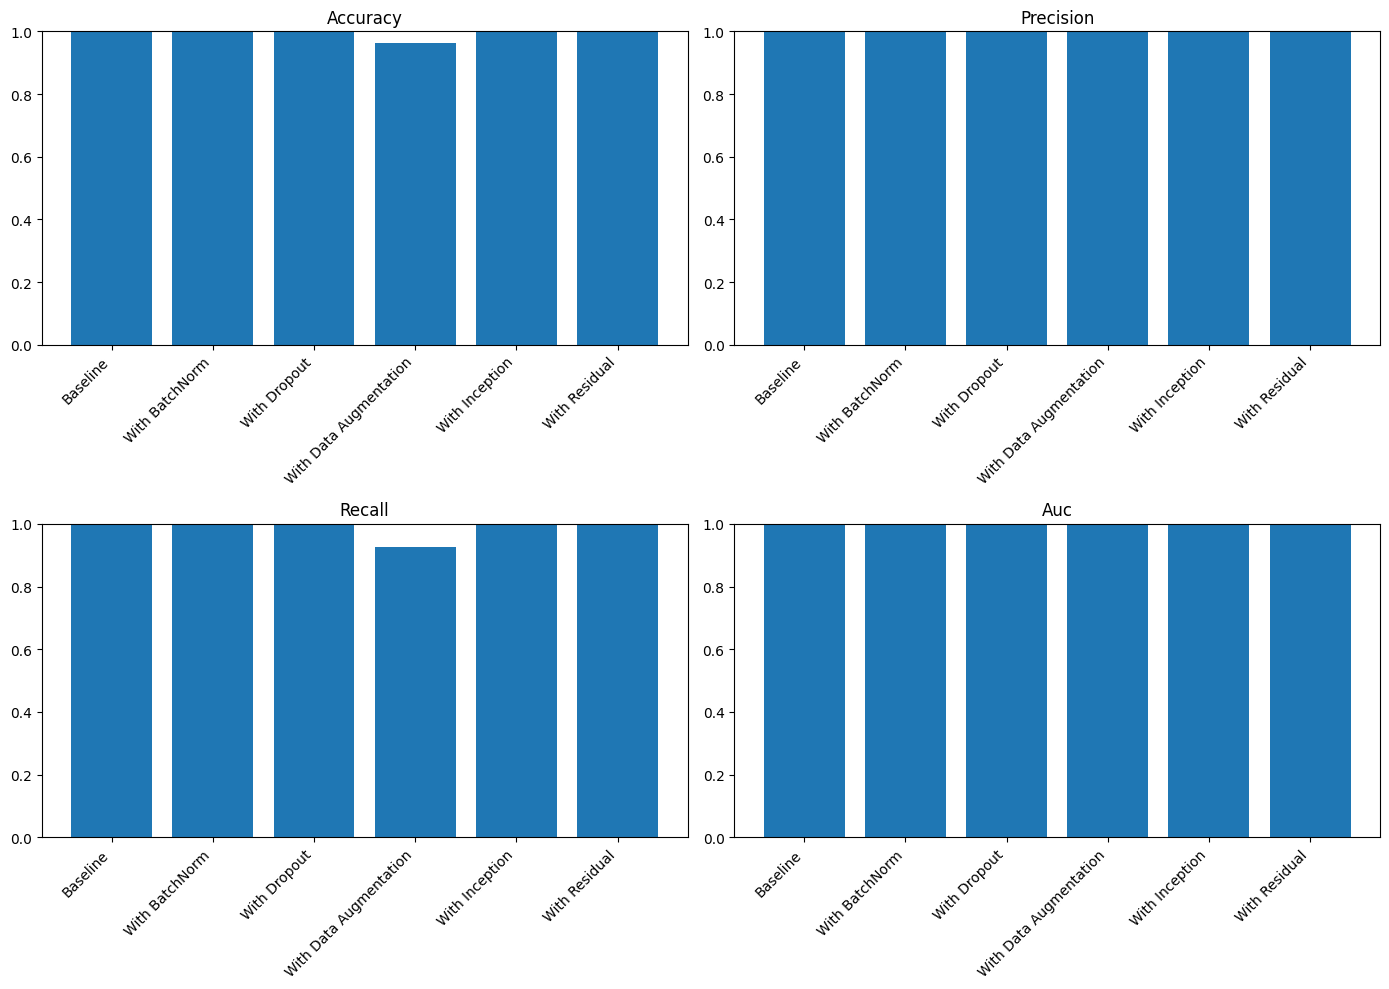

Comparison saved to model_results_20250316_005602\technique_comparison.csv


In [20]:
# BLOCK 11: Compare Different Techniques

# Collect results from all models
results = [
    {
        'name': 'Baseline',
        'test_accuracy': baseline_results['test_accuracy'],
        'test_precision': baseline_results['test_precision'],
        'test_recall': baseline_results['test_recall'],
        'test_auc': baseline_results['test_auc']
    },
    {
        'name': 'With BatchNorm',
        'test_accuracy': batchnorm_results['test_accuracy'],
        'test_precision': batchnorm_results['test_precision'],
        'test_recall': batchnorm_results['test_recall'],
        'test_auc': batchnorm_results['test_auc']
    },
    {
        'name': 'With Dropout',
        'test_accuracy': dropout_results['test_accuracy'],
        'test_precision': dropout_results['test_precision'],
        'test_recall': dropout_results['test_recall'],
        'test_auc': dropout_results['test_auc']
    },
    {
        'name': 'With Data Augmentation',
        'test_accuracy': augmentation_results['test_accuracy'],
        'test_precision': augmentation_results['test_precision'],
        'test_recall': augmentation_results['test_recall'],
        'test_auc': augmentation_results['test_auc']
    },
    {
        'name': 'With Inception',
        'test_accuracy': inception_results['test_accuracy'],
        'test_precision': inception_results['test_precision'],
        'test_recall': inception_results['test_recall'],
        'test_auc': inception_results['test_auc']
    },
    {
        'name': 'With Residual',
        'test_accuracy': residual_results['test_accuracy'],
        'test_precision': residual_results['test_precision'],
        'test_recall': residual_results['test_recall'],
        'test_auc': residual_results['test_auc']
    }
]

# Convert to DataFrame for better comparison
results_df = pd.DataFrame(results)
print("\nComparison of Techniques:")
print(results_df)

# Save results
results_df.to_csv(os.path.join(output_dir, "technique_comparison.csv"), index=False)

# Plot comparison
plt.figure(figsize=(14, 10))

metrics = ['test_accuracy', 'test_precision', 'test_recall', 'test_auc']
for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i+1)
    plt.bar(results_df['name'], results_df[metric])
    plt.title(metric.replace('test_', '').capitalize())
    plt.xticks(rotation=45, ha='right')
    plt.ylim([0, 1])

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "technique_comparison.png"))
plt.show()

# Save a summary of all experiments
pd.DataFrame(results).to_csv(os.path.join(output_dir, "all_experiments_summary.csv"), index=False)
print(f"Comparison saved to {os.path.join(output_dir, 'technique_comparison.csv')}")

In [ ]:
# BLOCK 12: Train Best Model (Combined Techniques)

# Define combined techniques configuration
best_config = {
    'name': 'Combined Techniques',
    'use_batchnorm': True,
    'dropout_rate': 0.3,
    'use_inception': True,
    'use_residual': True,
    'use_augmentation': True,
    'batch_size': 32,
    'epochs': 20  # Slight increase for final model
}

print(f"Training best model (combined techniques)...")
best_model, best_history = train_model(
    X_train, y_train, X_val, y_val, best_config, output_dir
)

# Evaluate best model
print(f"Evaluating best model...")
best_results = evaluate_model(
    best_model, X_test, y_test, best_config, output_dir
)

# Try to save model architecture visualization
try:
    from tensorflow.keras.utils import plot_model
    plot_model(best_model, to_file=os.path.join(output_dir, "model_architecture.png"), 
              show_shapes=True, show_layer_names=True)
    print(f"Model architecture saved to {os.path.join(output_dir, 'model_architecture.png')}")
except Exception as e:
    print(f"Error saving model architecture: {e}")

# Save the best model to disk
best_model_path = os.path.join(output_dir, "best_mixing_classification_model.h5")
best_model.save(best_model_path)
print(f"Best model saved to: {best_model_path}")

# Add combined techniques to results dataframe and update the comparison chart
all_results = results.copy()
all_results.append({
    'name': 'Combined Techniques',
    'test_accuracy': best_results['test_accuracy'],
    'test_precision': best_results['test_precision'],
    'test_recall': best_results['test_recall'],
    'test_auc': best_results['test_auc']
})

# Convert to DataFrame
all_results_df = pd.DataFrame(all_results)
print("\nFinal Comparison of All Techniques:")
print(all_results_df)

# Save updated results
all_results_df.to_csv(os.path.join(output_dir, "all_techniques_comparison.csv"), index=False)

# Plot updated comparison
plt.figure(figsize=(16, 10))

metrics = ['test_accuracy', 'test_precision', 'test_recall', 'test_auc']
for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i+1)
    bars = plt.bar(all_results_df['name'], all_results_df[metric])
    
    # Highlight the combined techniques bar
    bars[-1].set_color('red')
    
    plt.title(metric.replace('test_', '').capitalize())
    plt.xticks(rotation=45, ha='right')
    plt.ylim([0, 1])

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "all_techniques_comparison.png"))
plt.show()

# Save a comprehensive summary for the best model
best_summary = {
    'model': 'Combined Techniques',
    'parameters': best_config,
    'test_accuracy': best_results['test_accuracy'],
    'test_precision': best_results['test_precision'],
    'test_recall': best_results['test_recall'],
    'test_auc': best_results['test_auc'],
    'training_epochs': len(best_history.history['loss']),
    'final_val_accuracy': best_history.history['val_accuracy'][-1],
    'best_val_accuracy': max(best_history.history['val_accuracy'])
}

# Save as CSV
pd.DataFrame([best_summary]).to_csv(os.path.join(output_dir, "best_model_summary.csv"), index=False)

# Clear memory
tf.keras.backend.clear_session()
gc.collect()

Training best model (combined techniques)...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64, 64,    │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │      9,248 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │        544 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 32, 32,    │          0 │ add[0][0]         │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32, 32,    │          0 │ activation_1[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 16, 16,    │          0 │ dropout[0][0]     │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 16, 16,    │      1,584 │ max_pooling2d_1[… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16, 8) │        264 │ max_pooling2d_1[

 Total params: 1,099,033 (4.19 MB)

 Trainable params: 1,098,553 (4.19 MB)

 Non-trainable params: 480 (1.88 KB)

Epoch 1/20


C:\Users\pariy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.5876 - auc: 0.6221 - loss: 0.8049 - precision: 0.5937 - recall: 0.5986
Epoch 1: val_accuracy improved from -inf to 0.50333, saving model to model_results_20250316_005602\mixing_cnn_bn1_do0.3_inception1_residual1.h5


87/87 ━━━━━━━━━━━━━━━━━━━━ 15s 110ms/step - accuracy: 0.5884 - auc: 0.6231 - loss: 0.8032 - precision: 0.5944 - recall: 0.5995 - val_accuracy: 0.5033 - val_auc: 0.8172 - val_loss: 0.8383 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/20
 1/87 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step - accuracy: 0.7812 - auc: 0.8647 - loss: 0.4719 - precision: 0.7857 - recall: 0.7333

C:\Users\pariy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.50333
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7812 - auc: 0.8647 - loss: 0.4719 - precision: 0.7857 - recall: 0.7333 - val_accuracy: 0.5033 - val_auc: 0.7799 - val_loss: 0.8547 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.7830 - auc: 0.8680 - loss: 0.4540 - precision: 0.7823 - recall: 0.7958
Epoch 3: val_accuracy did not improve from 0.50333
87/87 ━━━━━━━━━━━━━━━━━━━━ 18s 213ms/step - accuracy: 0.7832 - auc: 0.8682 - loss: 0.4536 - precision: 0.7823 - recall: 0.7962 - val_accuracy: 0.5033 - val_auc: 0.8781 - val_loss: 1.6041 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/20
 1/87 ━━━━━━━━━━━━━━━━━━━━ 12s 142ms/step - accuracy: 0.8125 - auc: 0.8691 - loss: 0.4538 - precision: 0.8125 - recall: 0.8125
Epoch 4: val_accuracy did not improve from 0.50333

Epoch 4: ReduceLROnPlateau reducing learning 

Test data loaded successfully.
X_test shape: (600, 64, 64, 3)
y_test shape: (600,)
Class distribution - Test: [305 295]
Loading model from model_results_20250316_005602\best_mixing_classification_model.h5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64, 64,    │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │      9,248 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │        544 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 32, 32,    │          0 │ add[0][0]         │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32, 32,    │          0 │ activation_1[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 16, 16,    │          0 │ dropout[0][0]     │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 16, 16,    │      1,584 │ max_pooling2d_1[… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16, 8) │        264 │ max_pooling2d_1[

 Total params: 1,099,035 (4.19 MB)

 Trainable params: 1,098,553 (4.19 MB)

 Non-trainable params: 480 (1.88 KB)

 Optimizer params: 2 (12.00 B)

Evaluating model on test data...
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4815 - auc: 0.9565 - loss: 1.4625 - precision: 0.0000e+00 - recall: 0.0000e+00
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Test Loss: 1.3951
Test Accuracy: 0.5083
Test Precision: 0.0000
Test Recall: 0.0000
Test AUC: 0.9510

Confusion Matrix:
[[305   0]
 [295   0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.51      1.00      0.67       305
           1       0.00      0.00      0.00       295

    accuracy                           0.51       600
   macro avg       0.25      0.50      0.34       600
weighted avg       0.26      0.51      0.34       600



C:\Users\pariy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\pariy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\pariy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classificati

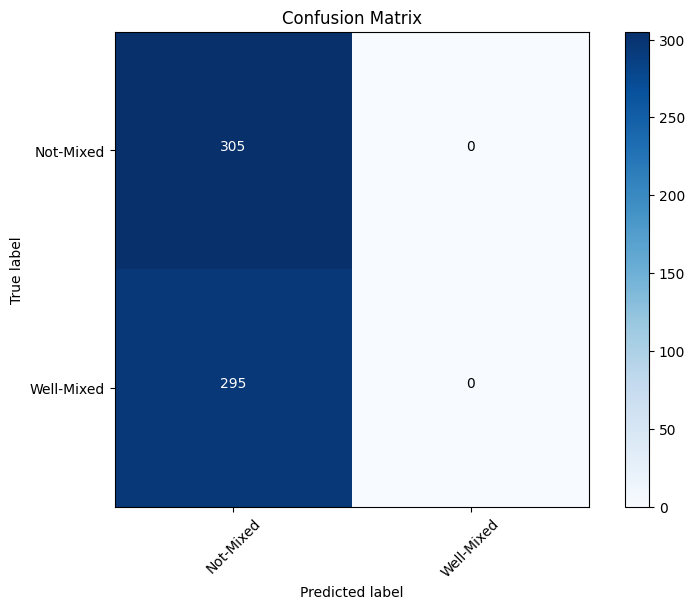

In [22]:
# BLOCK 13: Test Script for Loading and Evaluating Saved Model

def load_test_data(data_path="mixing_dataset_small"):
    """
    Load test data from saved numpy files
    
    Args:
        data_path: Path to directory containing saved data
    
    Returns:
        X_test, y_test: Test data
    """
    try:
        X_test = np.load(os.path.join(data_path, "X_test.npy"))
        y_test = np.load(os.path.join(data_path, "y_test.npy"))
        print(f"Test data loaded successfully.")
        print(f"X_test shape: {X_test.shape}")
        print(f"y_test shape: {y_test.shape}")
        print(f"Class distribution - Test: {np.bincount(y_test)}")
        return X_test, y_test
    except Exception as e:
        print(f"Error loading test data: {e}")
        return None, None

def test_saved_model(model_path, X_test, y_test):
    """
    Load and test a saved model
    
    Args:
        model_path: Path to saved model
        X_test, y_test: Test data
    
    Returns:
        model, results: Loaded model and evaluation results
    """
    try:
        # Load model
        print(f"Loading model from {model_path}")
        model = load_model(model_path)
        
        # Print model summary
        model.summary()
        
        # Evaluate model
        print("Evaluating model on test data...")
        results = model.evaluate(X_test, y_test, verbose=1)
        
        # Get predictions
        y_pred_prob = model.predict(X_test)
        y_pred = (y_pred_prob > 0.5).astype(int).flatten()
        
        # Print results
        print(f"Test Loss: {results[0]:.4f}")
        print(f"Test Accuracy: {results[1]:.4f}")
        print(f"Test Precision: {results[2]:.4f}")
        print(f"Test Recall: {results[3]:.4f}")
        print(f"Test AUC: {results[4]:.4f}")
        
        # Print confusion matrix and classification report
        cm = confusion_matrix(y_test, y_pred)
        print("\nConfusion Matrix:")
        print(cm)
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
        
        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title('Confusion Matrix')
        plt.colorbar()
        classes = ['Not-Mixed', 'Well-Mixed']
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)
        
        # Add text annotations
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                plt.text(j, i, format(cm[i, j], 'd'),
                        horizontalalignment="center",
                        color="white" if cm[i, j] > thresh else "black")
        
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.show()
        
        return model, results
        
    except Exception as e:
        print(f"Error testing model: {e}")
        return None, None

# Run this section to test the saved model
if __name__ == "__main__":
    # Clear any previous model from memory
    tf.keras.backend.clear_session()
    gc.collect()
    
    # Load the test data
    X_test, y_test = load_test_data()
    
    if X_test is not None and y_test is not None:
        # Find the most recent model results directory
        result_dirs = [d for d in os.listdir() if d.startswith("model_results_")]
        if result_dirs:
            latest_dir = max(result_dirs)  # Get the most recent directory
            model_path = os.path.join(latest_dir, "best_mixing_classification_model.h5")
            
            if os.path.exists(model_path):
                loaded_model, results = test_saved_model(model_path, X_test, y_test)
            else:
                print(f"Model file not found at {model_path}")
        else:
            print("No model results directory found")

Visualizing sample predictions...
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


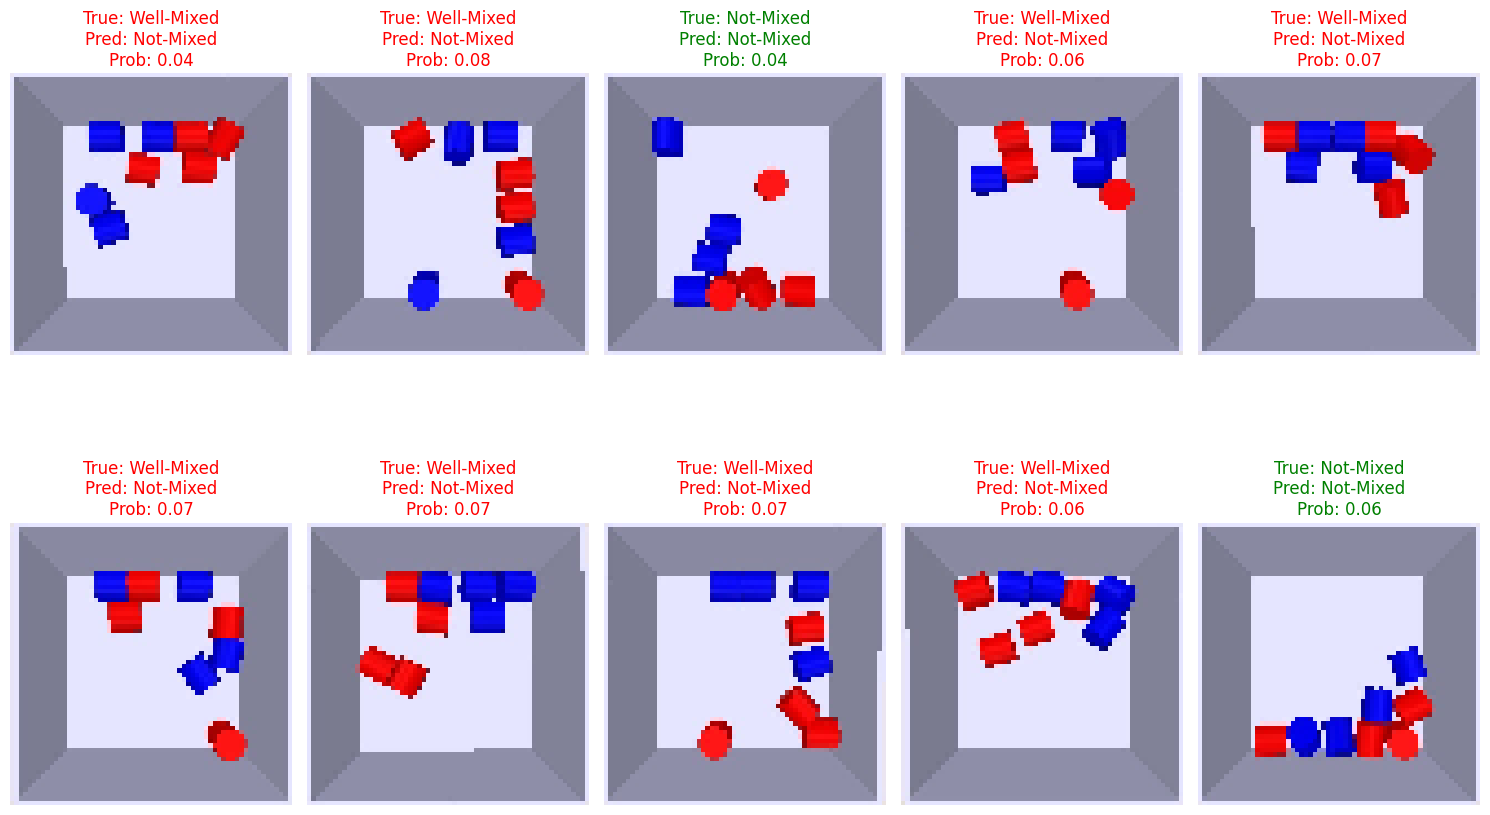

In [23]:
# BLOCK 14: Visualize Sample Predictions

def visualize_sample_predictions(model, X_test, y_test, num_samples=10):
    """
    Visualize sample predictions from the model
    
    Args:
        model: Trained model
        X_test, y_test: Test data
        num_samples: Number of samples to visualize
    """
    # Get predictions
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()
    
    # Get random indices
    indices = np.random.choice(len(X_test), num_samples, replace=False)
    
    # Create figure
    plt.figure(figsize=(15, 10))
    
    for i, idx in enumerate(indices):
        plt.subplot(2, 5, i+1)
        plt.imshow(X_test[idx])
        
        true_label = "Well-Mixed" if y_test[idx] == 1 else "Not-Mixed"
        pred_label = "Well-Mixed" if y_pred[idx] == 1 else "Not-Mixed"
        
        # Use green text for correct predictions, red for incorrect
        color = "green" if y_test[idx] == y_pred[idx] else "red"
        
        plt.title(f"True: {true_label}\nPred: {pred_label}\nProb: {y_pred_prob[idx][0]:.2f}", 
                 color=color)
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "sample_predictions.png"))
    plt.show()

# Run this if we have a loaded model
if 'loaded_model' in locals() and loaded_model is not None:
    print("Visualizing sample predictions...")
    visualize_sample_predictions(loaded_model, X_test, y_test)
elif 'best_model' in locals() and best_model is not None:
    print("Visualizing sample predictions from best model...")
    visualize_sample_predictions(best_model, X_test, y_test)